In [1]:
# IMPORTS
import os
import sys
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter, ScalarFormatter

from IPython.display import clear_output
from dask.diagnostics import ProgressBar
from tqdm.notebook import tqdm

# local clone of weatherbench2 found at : https://github.com/google-research/weatherbench2
sys.path.append('/scratch/dx2/cl6824/weatherbench2')
from weatherbench2 import schema
from weatherbench2.derived_variables import ZonalEnergySpectrum

In [4]:
# run to have loading bars
ProgressBar().register()

In [2]:
def compute_longitudinal_FFT(ds):
    """ Computes a Fourier transform at each latitude along longitudes
    ds (xr.Dataset) : a dataset with 'latitude', 'longitude' and 'time' coordinates, and 'wind_speed' variable.

    returns:
        xr.Dataset : a dataset with latitude and zonal_wavenumber coordinates.
    """

    ds = ds.load() # time consuming task, running the progress bar register makes a progress bar appear

    # compute FFT on wind_speed variable
    ZES = ZonalEnergySpectrum("wind_speed")
    res = ZES.compute(ds)

    # average on time to smooth the results
    res = res.mean(dim="time")
    return res

def reduce_to_barra2_domain(ds):
    """ Selects latitudes and longitudes in the BARRA2 AUS-22 domain"""
    latmin = -56.49
    latmax = 11.71
    lonmin = 89.53
    lonmax = 206.13
    ds = ds.sel(latitude=slice(latmin, latmax), longitude=slice(lonmin, lonmax))
    return ds

def tukey_1d(ds, alpha=0.2):
    """
    Tukey window 1D (alpha fraction for tapered region).
    """
    N = len(ds.longitude.values)
    if alpha <= 0:
        return np.ones(N)
    if alpha >= 1:
        return np.hanning(N)
    x = np.linspace(0, 1, N)
    w = np.ones(N)
    t = alpha / 2.0
    # rising cosine
    mask1 = x < t
    w[mask1] = 0.5 * (1 + np.cos(np.pi*(2*x[mask1]/alpha - 1)))
    # falling cosine
    mask2 = x > (1 - t)
    w[mask2] = 0.5 * (1 + np.cos(np.pi*(2*(x[mask2]-1)/alpha + 1)))
    return xr.DataArray(
        w,
        coords={"longitude": ds.longitude},
        dims="longitude",
        name="weights"
    )


### ERA5

In [37]:
def access_ERA5():
    # Retrieve all files (3 fields, 12 months)
    u_path = os.path.join("/g/data/rt52/era5", "pressure-levels", "reanalysis", "u", "2024")
    v_path = os.path.join("/g/data/rt52/era5", "pressure-levels", "reanalysis", "v", "2024")
    w_path = os.path.join("/g/data/rt52/era5", "pressure-levels", "reanalysis", "w", "2024")
    u_files = sorted([os.path.join(u_path, e) for e in os.listdir(u_path)])
    v_files = sorted([os.path.join(v_path, e) for e in os.listdir(v_path)])
    w_files = sorted([os.path.join(w_path, e) for e in os.listdir(w_path)])

    # select same days as AIFS and IFS runs, limit to one date per day to reduce computation cost (else, 24h=24 files per day)
    dates = [(datetime.strptime('20240101', '%Y%m%d') + timedelta(days=x*3)).strftime('%Y%m%d%H') for x in range(122)]
    dates = np.array([np.datetime64(datetime.strptime(d, '%Y%m%d%H')) for d in dates])
    
    def prep(ds):
        ds = ds.sel(time=ds.time.isin(dates))
        # select the desired pressure levels
        ds = ds.sel(level=[500, 200])
        return ds
    
    # Use open_mfdataset with preprocess
    ds = xr.open_mfdataset(
        u_files+v_files+w_files,
        combine='by_coords',
        preprocess=prep,
        chunks={}
    )

    # calculate kinetic energy
    ds["wind_speed"] = ds["u"]**2 + ds["v"]**2 + ds["w"]**2
    ds = ds.drop_vars(["u", "v", "w"])
    ds = ds.sortby("latitude")
    return ds

In [ ]:
ds = access_ERA5()

for elevel in [500, 200]:
    eds = ds.sel(level=elevel)

    # perform global FFT
    # res = compute_longitudinal_FFT(eds)
    # res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/ERA5/wind_speed_{elevel}hPa/{elevel}hPa_wind_speed_spectrum.nc")

    # perform BARRA2 domain FFT
    eds = reduce_to_barra2_domain(eds)
    weights = tukey_1d(eds)
    eds = eds * weights
    res = compute_longitudinal_FFT(eds)
    res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/ERA5/area/{elevel}hPa_wind_speed_spectrum.nc")

    print(f"level {elevel} done")

### AIFS

In [11]:
def access_AIFS(lead_time_index: int):
    """
    lead time index 0 is the first lead time (+6h), lead time = (lead_time_index + 1)*6
    """

    base_path = "/g/data/dx2/cl6824/ML/AIFS/outputs/postproc/v1/"
    files = [os.path.join(base_path, e) for e in os.listdir(base_path)]
    def prep(ds):
        # Select only the variables of interest
        ds = ds[["u", "v", "w"]]
        # Select a specific lead time
        ds = ds.isel(time=[lead_time_index])
        # select the desired pressure level
        ds = ds.sel(level=[500, 200])
        # Compute wind speed from u and v components
        ds["wind_speed"] = ds["u"]**2 + ds["v"]**2 + ds["w"]**2
        # Drop the original wind components
        ds = ds.drop_vars(["u", "v", "w"])
        ds = ds.sortby("latitude")
        return ds

    ds = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=prep,
        chunks={}
    )
    return ds

In [ ]:
max_lead_time = 40 # could go to 60 (60*6 = 360) but IFS stops at +240h so no need to do it all
lead_times = list(range(0, max_lead_time))

for lead_time_index in lead_times:
    clear_output(wait=True)

    print(f"doing lead time {lead_time_index}/{max_lead_time}")
    ds = access_AIFS(lead_time_index)

    for elevel in [500, 200]:
        eds = ds.sel(level=elevel)

        # perform global FFT
        # ds = compute_longitudinal_FFT(eds)
        # res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/AIFS/wind_speed_{elevel}hPa/{elevel}hPa_wind_speed_spectrum_leadtime_{(lead_time_index+1)*6:03d}h.nc")

        # perform BARRA2 domain FFT
        eds = reduce_to_barra2_domain(eds)
        weights = tukey_1d(eds)
        eds = eds * weights
        res = compute_longitudinal_FFT(eds)
        res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/AIFS/area/{elevel}hPa_wind_speed_spectrum_leadtime_{(lead_time_index+1)*6:03d}h.nc")

### IFS

In [13]:
def access_IFS():
    base_path = "/g/data/dx2/cl6824/ML/IFS/"
    files = sorted([os.path.join(base_path, el) for el in os.listdir(base_path) if el.endswith(".grib")])
    dates = [(datetime.strptime('20240101', '%Y%m%d') + timedelta(days=x*3, hours=12)).strftime('%Y%m%d%H') for x in range(122)]
    dates = np.array([np.datetime64(datetime.strptime(d, '%Y%m%d%H')) for d in dates])
    def prep(ds):
        ds = ds.sel(time=ds.time.isin(dates))
        ds["wind_speed"] = ds["u"]**2 + ds["v"]**2 + ds["w"]**2
        ds = ds.drop_vars(["u", "v", "w"])
        return ds
    
    ds = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=prep,
        chunks={},
        decode_timedelta=True
    )
    ds = ds.sortby("latitude")
    return ds

In [14]:
ds = access_IFS()

for elevel in [500, 200]:
    eds = ds.sel(isobaricInhPa=elevel)
    eds = eds.drop_vars(["number", "step"])

    # perform global FFT
    # res = compute_longitudinal_FFT(eds)
    # res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/IFS/wind_speed_{elevel}hPa/{elevel}hPa_wind_speed_spectrum.nc")

    # perform BARRA2 domain FFT
    eds = reduce_to_barra2_domain(eds)
    weights = tukey_1d(eds)
    eds = eds * weights
    res = compute_longitudinal_FFT(eds)
    res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/IFS/area/{elevel}hPa_wind_speed_spectrum.nc")
    print(f"level {elevel} done")

[########################################] | 100% Completed | 71.07 s
[########################################] | 100% Completed | 71.17 s
level 500 done
[########################################] | 100% Completed | 40.15 s
[########################################] | 100% Completed | 40.25 s
level 200 done


### IFS FC

In [10]:
def access_IFS_FC(lead_time_index: int):
    base_path = "/g/data/dx2/cl6824/ML/IFS_FC/"
    files = sorted([os.path.join(base_path, el) for el in os.listdir(base_path) if el.endswith(".grib")])
    dates = [(datetime.strptime('20240101', '%Y%m%d') + timedelta(days=x*3, hours=12)).strftime('%Y%m%d%H') for x in range(122)]
    dates = np.array([np.datetime64(datetime.strptime(d, '%Y%m%d%H')) for d in dates])

    def prep(ds):
        # Select only the variables of interest
        ds = ds[["u", "v", "w"]]
        # Select a specific lead time
        ds = ds.isel(step=[lead_time_index])
        # select the desired pressure level
        ds = ds.sel(isobaricInhPa=[500, 200])
        # Compute wind speed from u and v components
        ds["wind_speed"] = ds["u"]**2 + ds["v"]**2 + ds["w"]**2
        # Drop the original wind components
        ds = ds.drop_vars(["u", "v", "w"])
        ds = ds.sortby("latitude")
        return ds

    ds = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=prep,
        chunks="auto",
        backend_kwargs={
            "decode_timedelta": True   # ou False selon ton cas
        }
    )
    return ds


In [ ]:
max_lead_time = 40
lead_times = list(range(9, max_lead_time))

for lead_time_index in lead_times:
    clear_output(wait=True)
    print(f"doing lead time {lead_time_index}/{max_lead_time}")

    ds = access_IFS_FC(lead_time_index)

    for elevel in [500]:
        print(f"doing level {elevel}")
        eds = ds.sel(isobaricInhPa=elevel)
        eds = eds.drop_vars(["step"])

        # perform global FFT
        # res = compute_longitudinal_FFT(eds)
        # res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/IFS_FC/wind_speed_{elevel}hPa/{elevel}hPa_wind_speed_spectrum_leadtime_{(lead_time_index+1)*6:03d}h.nc")

        # perform BARRA2 domain FFT
        eds = reduce_to_barra2_domain(eds)
        weights = tukey_1d(eds)
        eds = eds * weights
        res = compute_longitudinal_FFT(eds)
        res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/IFS_FC/area/{elevel}hPa_wind_speed_spectrum_leadtime_{(lead_time_index+1)*6:03d}h.nc")

doing lead time 18/40
doing level 500
[                                        ] | 0% Completed | 1.14 s ms

### AIFS - ENS

In [15]:
def access_AIFS_ENS(lead_time_index: int):
    base_path = "/g/data/dx2/cl6824/ML/AIFS/outputs/postproc/ens/ensv1"
    files = [os.path.join(base_path, e) for e in os.listdir(base_path) if e.startswith("ifs")] # startswith "ifs" to avoid initial condition files
    def prep(ds):
        # Select only the variables of interest
        ds = ds[["u", "v", "w"]]
        # Select a specific lead time
        ds = ds.isel(time=[lead_time_index+2]) # it looks like the IC are included (-6h and 0h, so +2 to be consistent with AIFS)
        # select the desired pressure level
        ds = ds.sel(level=[500, 200])
        # Compute wind speed from u and v components
        ds["wind_speed"] = ds["u"]**2 + ds["v"]**2 + ds["w"]**2
        # Drop the original wind components
        ds = ds.drop_vars(["u", "v", "w"])
        return ds

    ds = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=prep,
        chunks={}
    )
    ds = ds.sortby("latitude")
    return ds

In [ ]:
max_lead_time = 40
lead_times = list(range(0, max_lead_time))

for lead_time_index in lead_times:
    clear_output(wait=True)
    print(f"doing lead time {lead_time_index}/{max_lead_time}")
    ds = access_AIFS_ENS(lead_time_index)

    for elevel in [500, 200]:
        print(f"doing level {elevel}")
        eds = ds.sel(level=elevel)

        # perform global FFT
        # res = compute_longitudinal_FFT(eds)
        # res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/AIFS_ens/wind_speed_{elevel}hPa/{elevel}hPa_wind_speed_spectrum_leadtime_{(lead_time_index+1)*6:03d}h.nc")

        # perform BARRA2 domain FFT
        eds = reduce_to_barra2_domain(eds)
        weights = tukey_1d(eds)
        eds = eds * weights
        res = compute_longitudinal_FFT(eds)
        res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/AIFS_ens/area/{elevel}hPa_wind_speed_spectrum_leadtime_{(lead_time_index+1)*6:03d}h.nc")

### BARRA2

In [33]:
def access_BARRA2(level):
    dates = [(datetime.strptime('20240101', '%Y%m%d') + timedelta(days=x*3, hours=12)).strftime('%Y%m%d%H') for x in range(122)]
    dates = np.array([np.datetime64(datetime.strptime(d, '%Y%m%d%H')) for d in dates])
    u_level = f"/g/data/ob53/BARRA2/output/reanalysis/AUS-22/BOM/ERA5/historical/eda/BARRA-RE2/v1/1hr/ua{level}/v20250528"
    ufiles = [os.path.join(u_level, el) for el in os.listdir(u_level) if el[-9:-5] == "2024"]
    v_level = f"/g/data/ob53/BARRA2/output/reanalysis/AUS-22/BOM/ERA5/historical/eda/BARRA-RE2/v1/1hr/va{level}/v20250528"
    vfiles = [os.path.join(v_level, el) for el in os.listdir(v_level) if el[-9:-5] == "2024"]
    w_level = f"/g/data/ob53/BARRA2/output/reanalysis/AUS-22/BOM/ERA5/historical/eda/BARRA-RE2/v1/1hr/wa{level}/v20250528"
    wfiles = [os.path.join(w_level, el) for el in os.listdir(w_level) if el[-9:-5] == "2024"]

    def prep(ds):
        ds = ds.sel(time=ds.time.isin(dates))
        ds = ds.sel(realization='ctl_0')
        ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})
        return ds
    ds = xr.open_mfdataset(ufiles+vfiles+wfiles,
        combine='by_coords',
        preprocess=prep,
        chunks={},
        decode_timedelta=True
    )
    ds["wind_speed"] = ds[f"ua{level}"]**2 + ds[f"va{level}"]**2 + ds[f"wa{level}"]**2
    ds = ds.drop_vars([f"ua{level}", f"va{level}", f"wa{level}"])
    ds = ds.sortby("latitude")
    return ds

In [ ]:
levels = [500, 200]

for elevel in levels:
    ds = access_BARRA2(elevel)

    # perform BARRA2 domain FFT
    W = tukey_1d(len(ds.longitude.values))
    nds = ds * W
    res = compute_longitudinal_FFT(nds)

    res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/BARRA2/area/{elevel}hPa_wind_speed_spectrum.nc")
    

### TESTS

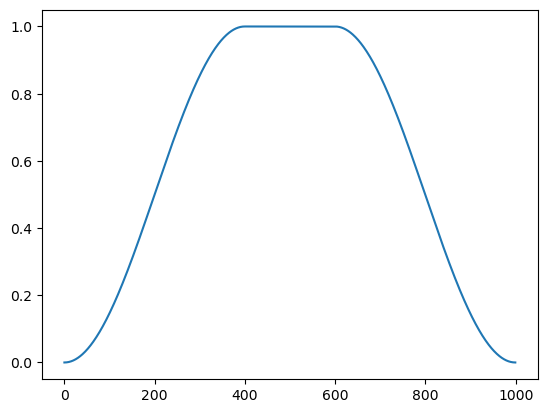

In [16]:
src = xr.DataArray(
        np.zeros(1000),
        coords={"longitude": np.arange(0, 1000, 1)},
        dims="longitude",
        name="weights"
    )
ds = tukey_1d(src, 0.8)
plt.plot(ds)

### BIN

#### Old ERA5 code with temporary files

In [ ]:
print("starting")
# Loop on all months
for i in range(len(u_files)):
    print(f"making files n°{i+1}/12")
    
    # store a file of kinetic energy per month
    ds.to_netcdf(f"/scratch/dx2/cl6824/Fourier/ERA5/tmp/times_{i:02d}.nc")


# Calculate spectra of each monthly file
base_path = "/scratch/dx2/cl6824/Fourier/ERA5/tmp"
files = os.listdir(base_path)
files = sorted([os.path.join(base_path, efile) for efile in files if (efile.endswith(".nc") and efile.startswith("times"))])

for i, efile in enumerate(files):
    print(f"performing file n°{i}/12")
    ds = xr.open_dataset(efile)
    for elevel in [200, 500]:
        print("loading")
        eds = ds.sel(level=elevel)
        eds = eds.load()
        print("computing ZES")
        ZES = ZonalEnergySpectrum("wind_speed")
        res = ZES.compute(eds)
        print("saving results")
        res.to_netcdf(f"/scratch/dx2/cl6824/Fourier/ERA5/tmp/fourier_{elevel}hPa_{i:02d}.nc")


# Combine spectras in a final file over all year
base_path = "/scratch/dx2/cl6824/Fourier/ERA5/tmp"
ffiles = [efile for efile in os.listdir(base_path) if efile.startswith("fourier")]
for elevel in [200, 500]:
    files_level = [os.path.join(base_path, efile) for efile in ffiles if efile.split("_")[1] == str(elevel)+"hPa"]
    ds_level = xr.open_mfdataset(files_level,
            combine='by_coords',
            chunks={}
        )
    ds_level = ds_level.mean(dim="time")
    ds_level.to_netcdf(f"/scratch/dx2/cl6824/Fourier/ERA5/wind_speed_{elevel}hPa/{elevel}hPa_wind_speed_spectrum.nc")